<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
# Tiny ML on Arduino
## Gesture recognition tutorial
 * Sandeep Mistry - Arduino
 * Don Coleman - Chariot Solutions


https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

## Setup Python Environment

The next cell sets up the dependencies in required for the notebook, run it.

In [1]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow

# Upload Data

1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the files tab
1. Drag `punch.csv` and `flex.csv` files from your computer to the tab to upload them into colab.

# Graph Data (optional)

We'll graph the input files on two separate graphs, acceleration and gyroscope, as each data set has different units and scale.

<ipython-input-2-93732dea61dc>:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
<ipython-input-2-93732dea61dc>:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
<ipython-input-2-93732dea61dc>:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')


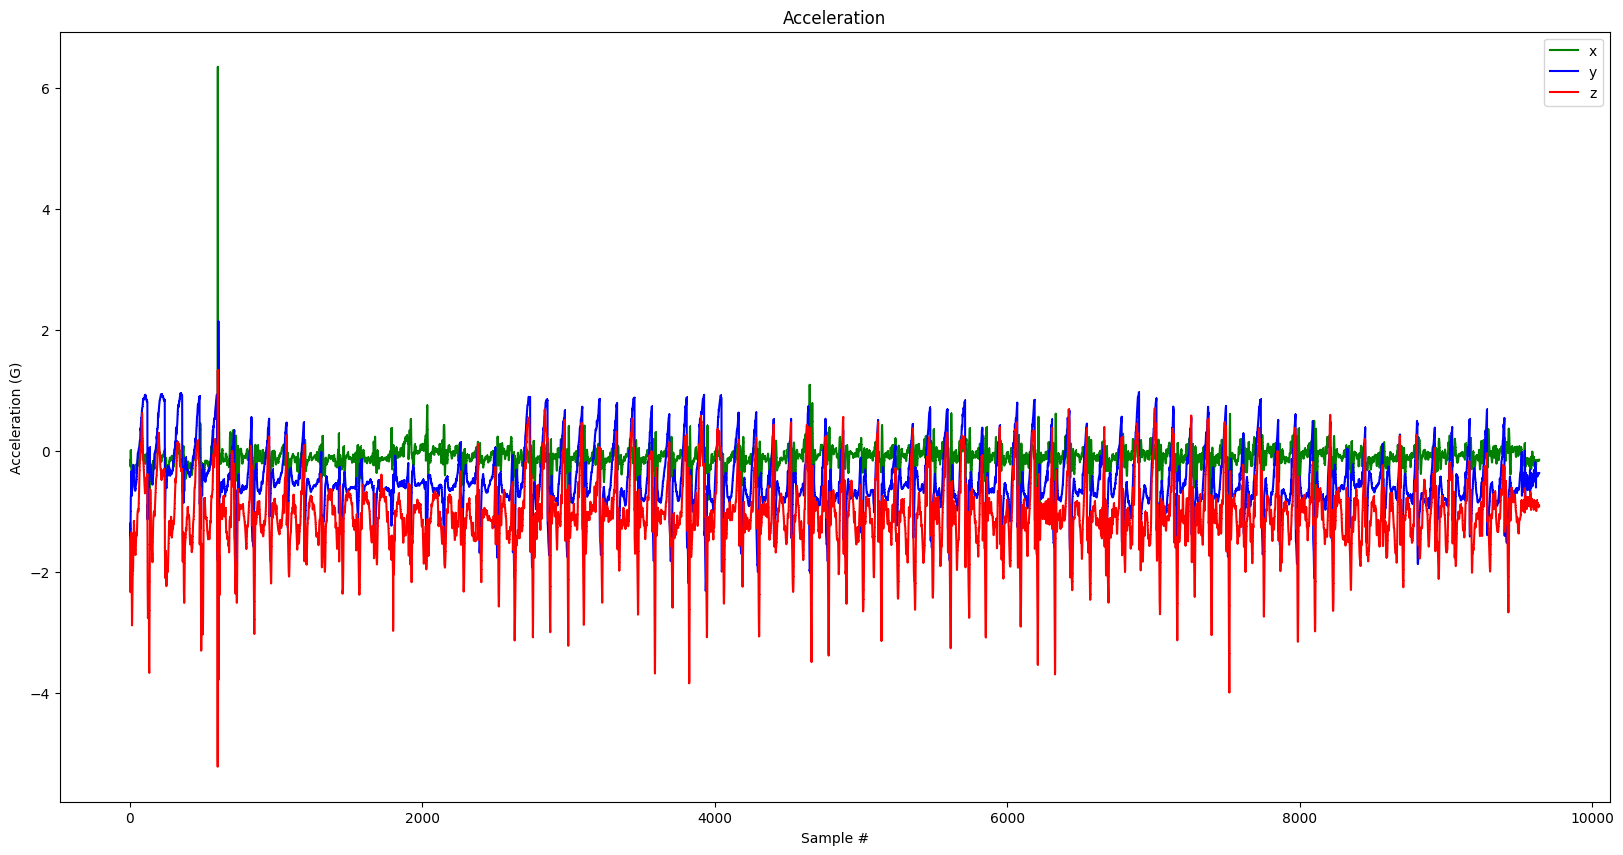

<ipython-input-2-93732dea61dc>:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
<ipython-input-2-93732dea61dc>:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
<ipython-input-2-93732dea61dc>:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')


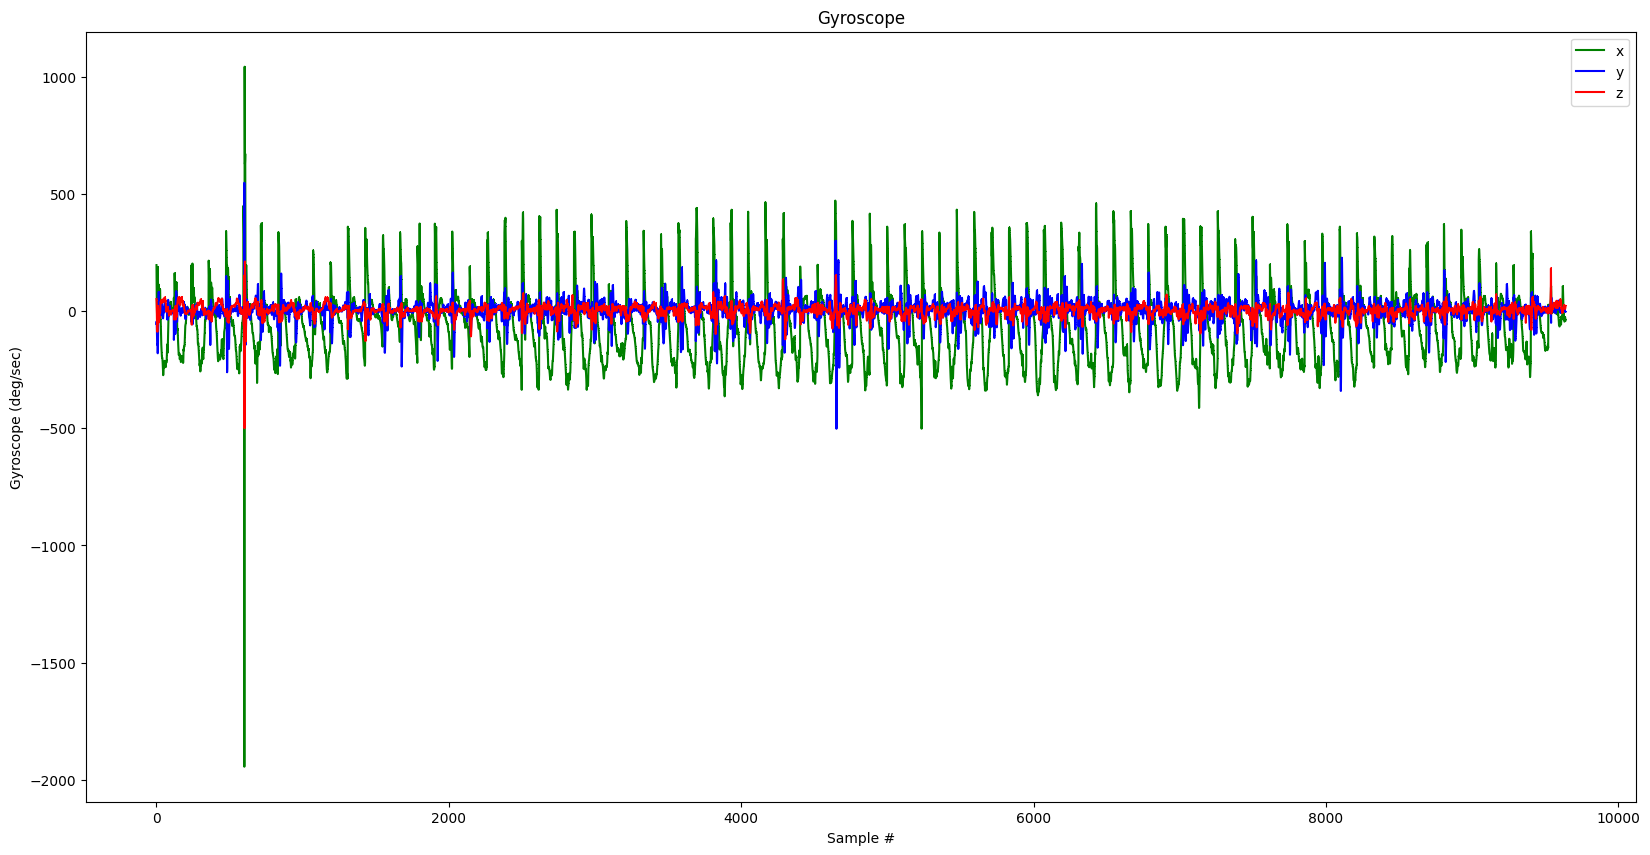

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "bow.csv"

df = pd.read_csv("/content/" + filename)

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()


# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `GESTURES` list with the gesture data you've collected in `.csv` format.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "bow",
    "circle",
    "sleep"
]

SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")

  output = ONE_HOT_ENCODED_GESTURES[gesture_index]

  df = pd.read_csv("/content/" + gesture + ".csv")

  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.17.1

Processing index 0 for gesture 'bow'.
	There are 81 recordings of the bow gesture.
Processing index 1 for gesture 'circle'.
	There are 72 recordings of the circle gesture.
Processing index 2 for gesture 'sleep'.
	There are 84 recordings of the sleep gesture.
Data set parsing and preparation complete.


## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [4]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [6]:
model = tf.keras.Sequential([
    # Define input_shape to ensure layers initialize properly
    tf.keras.layers.Dense(16, activation='relu', input_shape=(inputs_train.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # better for classification
    metrics=['accuracy']
)

# Use EarlyStopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Fit the model
history = model.fit(
    inputs_train,
    outputs_train,
    epochs=200,
    batch_size=8,
    validation_data=(inputs_validate, outputs_validate),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.3609 - loss: 1.1124 - val_accuracy: 0.5833 - val_loss: 1.0893
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4567 - loss: 1.0733 - val_accuracy: 0.6042 - val_loss: 1.0610
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6110 - loss: 1.0390 - val_accuracy: 0.5833 - val_loss: 1.0131
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5725 - loss: 1.0003 - val_accuracy: 0.5625 - val_loss: 0.9815
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5235 - loss: 0.9564 - val_accuracy: 0.5625 - val_loss: 0.9295
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5739 - loss: 0.9057 - val_accuracy: 0.5625 - val_loss: 0.8765
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6911 - loss: 0.8484 - val_accuracy: 0.5417 - val_loss: 0.8316
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7356 - loss: 0.7903 - val_accuracy: 0.8542 - 

## Verify

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

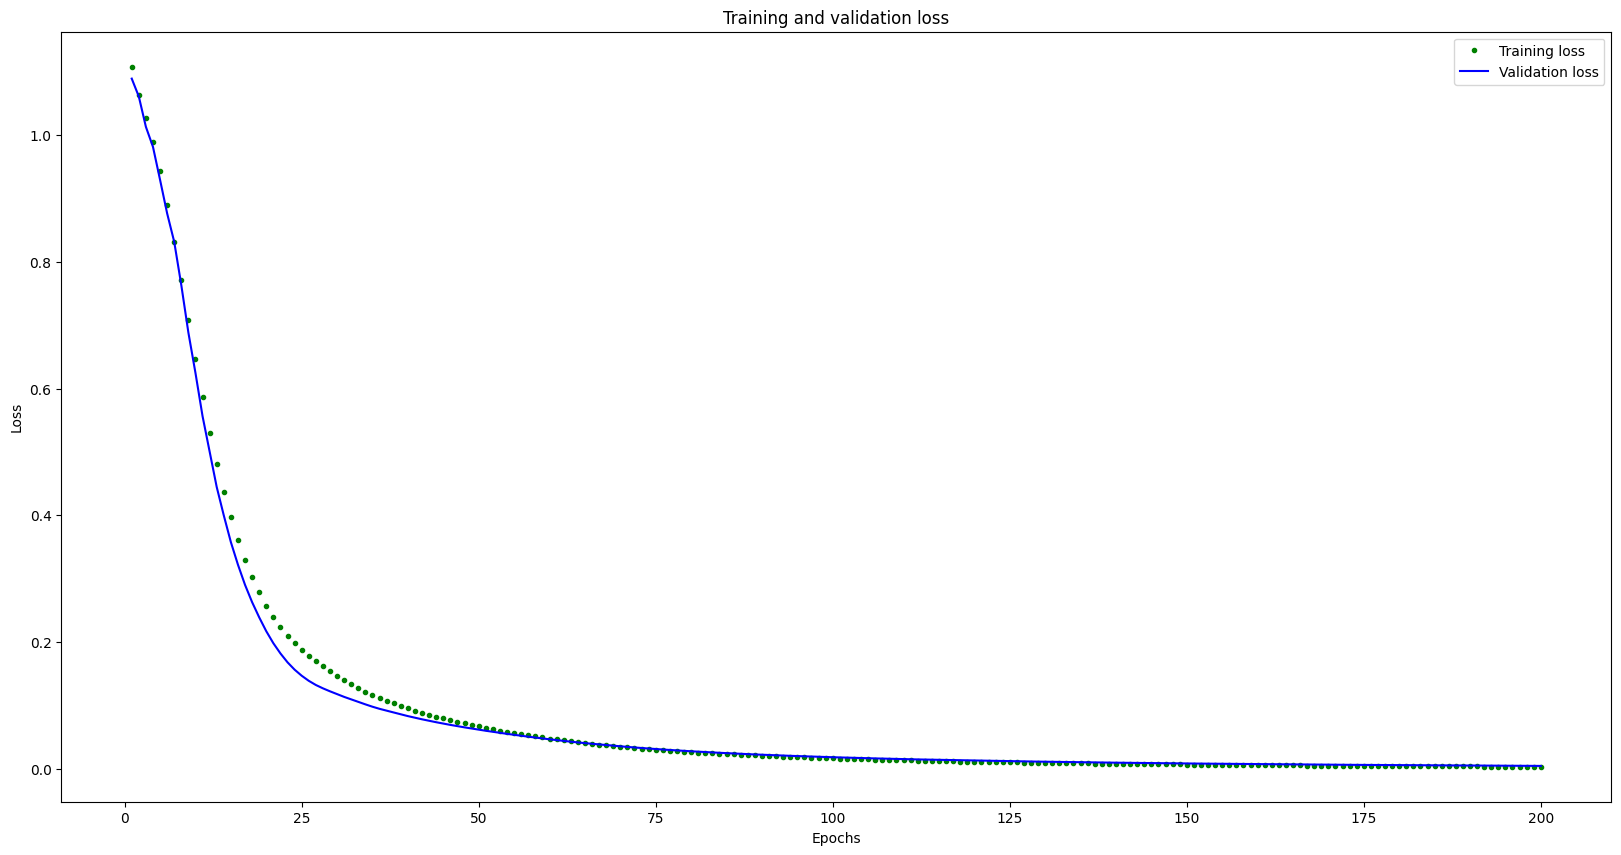

[20.0, 10.0]


In [8]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Graph the loss again, skipping a bit of the start

We'll graph the same data as the previous code cell, but start at index 100 so we can further zoom in once the model starts to converge.

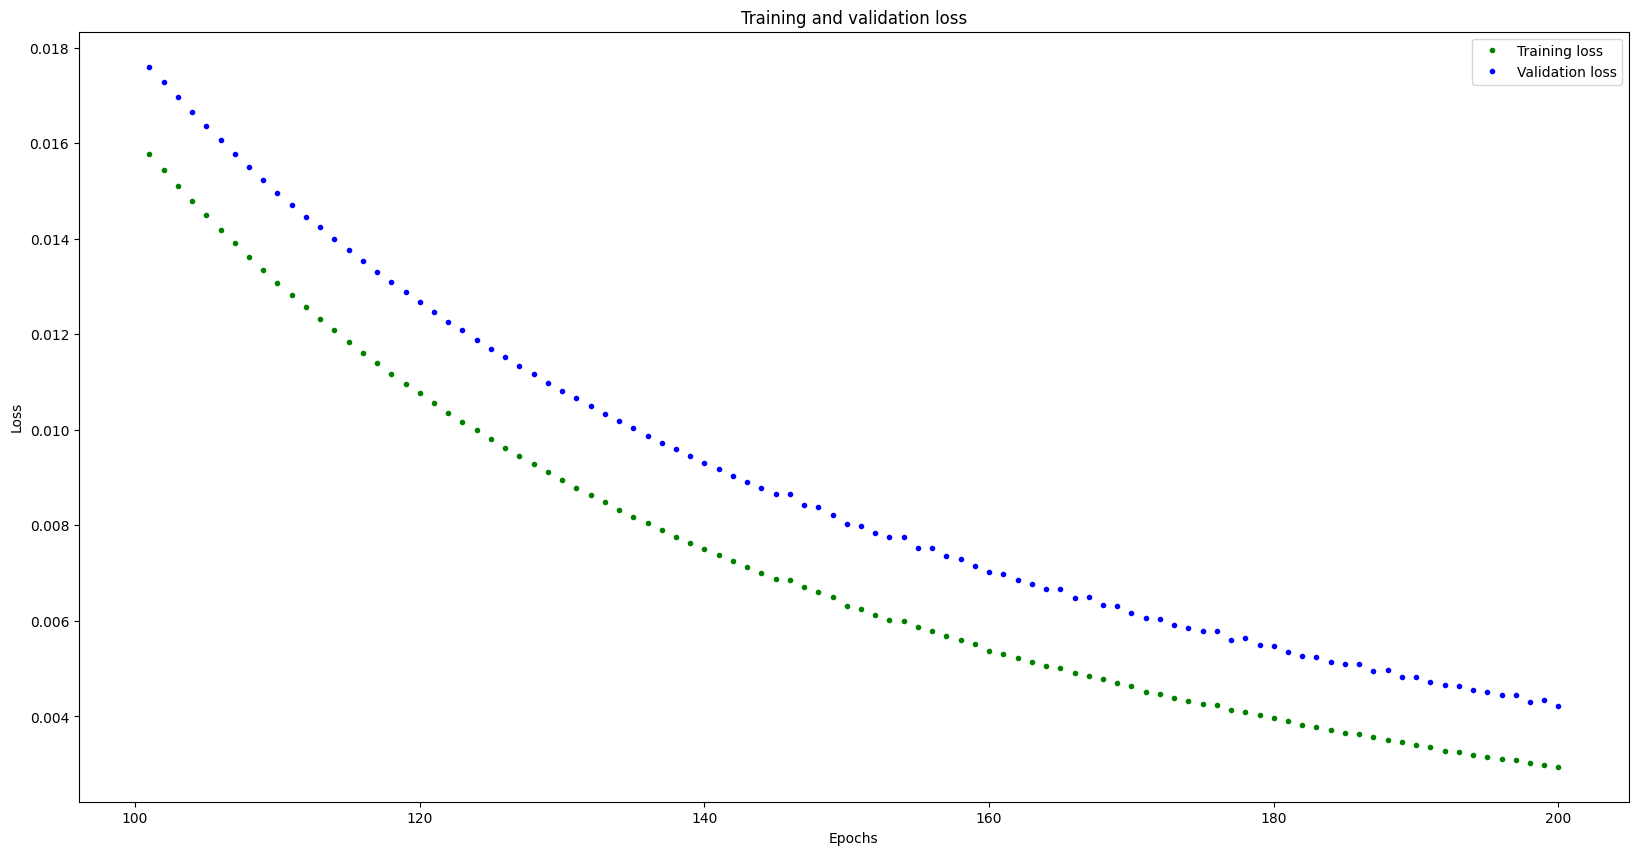

In [9]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Graph the mean absolute error

[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) is another metric to judge the performance of the model.



In [10]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


KeyError: 'mae'

### Run with Test Data
Put our test data into the model and plot the predictions


In [11]:
print(inputs_test.shape)
print(outputs_test.shape)

(47, 714)
(47, 3)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step
predictions =
 [[0.    1.    0.   ]
 [0.    0.    1.   ]
 [0.    1.    0.   ]
 [0.002 0.998 0.   ]
 [0.    0.    1.   ]
 [0.001 0.999 0.   ]
 [0.005 0.995 0.   ]
 [0.001 0.001 0.999]
 [0.001 0.011 0.988]
 [0.    1.    0.   ]
 [0.999 0.001 0.   ]
 [1.    0.    0.   ]
 [0.013 0.987 0.   ]
 [1.    0.    0.   ]
 [0.002 0.998 0.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.995 0.002 0.004]
 [0.    0.    1.   ]
 [1.    0.    0.   ]
 [0.    0.    1.   ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    1.    0.   ]
 [0.    0.    1.   ]
 [1.    0.    0.   ]
 [0.    1.    0.   ]
 [0.002 0.026 0.972]
 [0.017 0.975 0.008]
 [0.    1.    0.   ]
 [1.    0.    0.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.999 0.001 0.001]
 [0.999 0.001 0.   ]
 

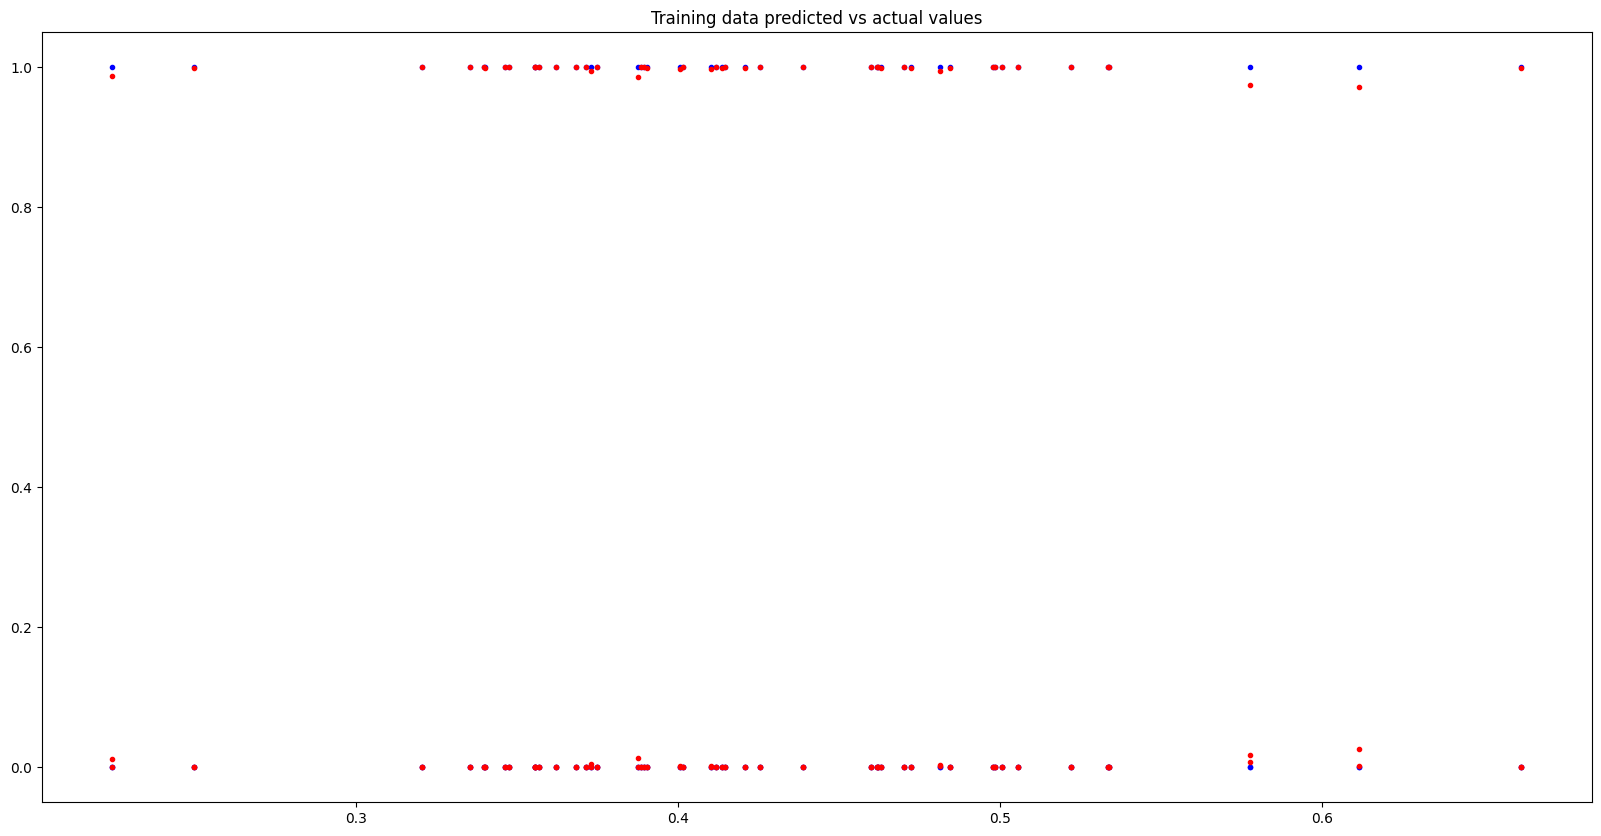

In [12]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test[:, 0], outputs_test, 'b.', label='Actual')
plt.plot(inputs_test[:, 0], predictions, 'r.', label='Predicted')
plt.show()

In [13]:
# -----------------------------------------------------------------------------
# 3. Evaluate Model on Test Set
# -----------------------------------------------------------------------------
test_loss, test_accuracy = model.evaluate(inputs_test, outputs_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Make some predictions
predictions = model.predict(inputs_test)
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

Test Loss: 0.0023, Test Accuracy: 1.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
predictions =
 [[0.    1.    0.   ]
 [0.    0.    1.   ]
 [0.    1.    0.   ]
 [0.002 0.998 0.   ]
 [0.    0.    1.   ]
 [0.001 0.999 0.   ]
 [0.005 0.995 0.   ]
 [0.001 0.001 0.999]
 [0.001 0.011 0.988]
 [0.    1.    0.   ]
 [0.999 0.001 0.   ]
 [1.    0.    0.   ]
 [0.013 0.987 0.   ]
 [1.    0.    0.   ]
 [0.002 0.998 0.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.995 0.002 0.004]
 [0.    0.    1.   ]
 [1.    0.    0.   ]
 [0.    0.    1.   ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    1.    0.   ]
 [0.    0.    1.   ]
 [1.    0.    0.   ]
 [0.    1.    0.   ]
 [0.002 0.026 0.972]
 [0.017 0.975 0.008]
 [0.    1.    0.   ]
 [1.    0.    0.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [14]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)



Saved artifact at '/tmp/tmpwb27wxbc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 714), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(1, 3), dtype=tf.float32, name=None)
Captures:
  132361430767696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132361426103536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132361426100720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132361426306144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132361426305440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132361426308784: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model is 148232 bytes


In [15]:
import os
# -----------------------------------------------------------------------------
# 4. Convert to TensorFlow Lite (Full Float)
#    Then do optional int8 quantization to minimize the model size.
# -----------------------------------------------------------------------------
# -- (A) Basic float TFLite model:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("gesture_model_float.tflite", "wb").write(tflite_model)

float_model_size = os.path.getsize("gesture_model_float.tflite")
print(f"Float Model size: {float_model_size} bytes")

# -- (B) Post-Training INT8 Quantization for size reduction:
def representative_data_gen():
    # Generator that provides a small subset of your data
    for i in range(0, inputs_train.shape[0], 1):
        # Model expects a list of input arrays
        yield [inputs_train[i:i+1].astype(np.float32)]

converter_int8 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
converter_int8.representative_dataset = representative_data_gen
# Force use of only INT8 operations
converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# If you want int8 in/out, uncomment lines below:
# converter_int8.inference_input_type = tf.int8
# converter_int8.inference_output_type = tf.int8

tflite_quant_model = converter_int8.convert()
open("gesture_model_int8.tflite", "wb").write(tflite_quant_model)

int8_model_size = os.path.getsize("gesture_model_int8.tflite")
print(f"INT8 Quantized model size: {int8_model_size} bytes")


Saved artifact at '/tmp/tmpah_dufzx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 714), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135605134934256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135605078446976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135605078448912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135605078443984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135605078443280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135605078448736: TensorSpec(shape=(), dtype=tf.resource, name=None)
Float Model size: 48500 bytes
Saved artifact at '/tmp/tmp0p6xakwb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 714), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Capt

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


## Encode the Model in an Arduino Header File

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [15]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 914,132 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


In [16]:
# -----------------------------------------------------------------------------
# 5. Export as C array (model.h) for Arduino (Optional)
# -----------------------------------------------------------------------------
with open("gesture_model_int8.tflite", "rb") as f:
    raw_bytes = f.read()

with open("model.h", "w") as f:
    f.write("const unsigned char model[] = {\n")
    # Format the bytes into C array format
    for i, val in enumerate(raw_bytes):
        if (i+1) % 12 == 0:
            f.write(f"0x{val:02x},\n")
        else:
            f.write(f"0x{val:02x}, ")
    f.write("};\n")

model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nDone! Upload 'model.h' to your Arduino project to use this model.")

Header file, model.h, is 90,899 bytes.

Done! Upload 'model.h' to your Arduino project to use this model.


# Classifying IMU Data

Now it's time to switch back to the tutorial instructions and run our new model on the Arduino Nano 33 BLE Sense to classify the accelerometer and gyroscope data.
